In [2]:
import pandas as pd
from sklearn import model_selection, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import optuna
import lightgbm as lgb
import numpy as np
import joblib
from scipy.sparse import hstack
from sklearn.decomposition import LatentDirichletAllocation
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=8)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Hyperparameter Optimization -- pg.50-52

In [6]:
dataset = pd.read_json('resources/embold_train.json')
dataset.loc[dataset['label'] > 0, 'label'] = -1
dataset.loc[dataset['label'] == 0, 'label'] = 1
dataset.loc[dataset['label'] == -1, 'label'] = 0
data_texts = pd.read_parquet("resources/data_texts.parquet")


In [19]:
y = dataset['label'].copy()
del dataset
data_fit, data_blindtest, y_fit, y_blindtest = model_selection.train_test_split(data_texts, y, test_size=0.2, stratify=y)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_vectorizer.fit(data_texts["title"] + data_texts["body"])
X_tfidf_fit = tfidf_vectorizer.transform(data_fit["title"] + data_fit["body"])
X_tfidf_blindtest = tfidf_vectorizer.transform(data_blindtest["title"] + data_blindtest["body"])


In [8]:
def objective(trial):
    dtrain = lgb.Dataset(X_tfidf_fit, label=y_fit)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_tfidf_blindtest)
    pred_labels = np.rint(preds)
    accuracy = metrics.roc_auc_score(y_blindtest, pred_labels)
    return accuracy


In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=16)
joblib.dump(study, "resources/study.pkl")


[I 2024-03-09 08:06:03,129] A new study created in memory with name: no-name-b99bfd57-fd01-43d6-ae24-862a55fed263


[I 2024-03-09 08:06:09,169] Trial 0 finished with value: 0.7819462028358932 and parameters: {'lambda_l1': 0.23429205712985515, 'lambda_l2': 1.2181231440789545e-07, 'num_leaves': 24, 'feature_fraction': 0.49709944370908093, 'bagging_fraction': 0.7233838824940806, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 0 with value: 0.7819462028358932.
[I 2024-03-09 08:06:22,707] Trial 1 finished with value: 0.7932872120328287 and parameters: {'lambda_l1': 2.3381233598882014e-08, 'lambda_l2': 3.7431171058727743e-08, 'num_leaves': 112, 'feature_fraction': 0.8031206497997677, 'bagging_fraction': 0.7239374783479332, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 1 with value: 0.7932872120328287.
[I 2024-03-09 08:07:01,135] Trial 2 finished with value: 0.7943254473061107 and parameters: {'lambda_l1': 5.202331180619743e-05, 'lambda_l2': 2.641199438779816e-07, 'num_leaves': 168, 'feature_fraction': 0.884969600735241, 'bagging_fraction': 0.8177550191070927, 'bagging_freq': 4, 'mi

In [12]:
gbm_model = lgb.LGBMClassifier(**study.best_params)
scoring = {"precision": "precision_macro", "recall": "recall_macro", "f1": "f1_macro"}
scores = model_selection.cross_validate(
    gbm_model,
    X_tfidf_fit,
    y_fit,
    cv=4,
    n_jobs=-1,
    scoring=scoring,
    return_train_score=True,
    verbose=1,
)

print(
    "fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}".format(
        scores["train_precision"].mean(),
        scores["train_recall"].mean(),
        scores["train_f1"].mean(),
    )
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fit: p:0.8614 r:0.8601 f:0.8607


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.4min finished


In [13]:
gbm_model.fit(
    X_tfidf_fit, y_fit, eval_set=[(X_tfidf_blindtest, y_blindtest)], eval_metric="AUC"
)
precision_test_score = metrics.precision_score(
    gbm_model.predict(X_tfidf_blindtest), y_blindtest, average="macro"
)
recall_test_score = metrics.recall_score(
    gbm_model.predict(X_tfidf_blindtest), y_blindtest, average="macro"
)
f1_test_score = metrics.f1_score(
    gbm_model.predict(X_tfidf_blindtest), y_blindtest, average="macro"
)
print(
    "test: p:{0:.4f} r:{1:.4f} f:{2:.4f}".format(
        precision_test_score, recall_test_score, f1_test_score
    )
)


[LightGBM] [Warning] feature_fraction is set=0.7556709840694132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7556709840694132
[LightGBM] [Warning] lambda_l2 is set=6.558592381248035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.558592381248035
[LightGBM] [Warning] lambda_l1 is set=1.0280044889945528e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0280044889945528e-06
[LightGBM] [Warning] bagging_fraction is set=0.5854978074679997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5854978074679997
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7556709840694132, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7556709840694132
[LightGBM] [Warning] lambda_l2 is set=6.558592381248035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.558592381248035
[LightGBM] [Warning] lambda_l1 i

## in class activity -- pg.53

In [28]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1))
count_vectorizer.fit(data_texts["title"] + data_texts["body"])
X_tf = count_vectorizer.transform(data_texts["title"] + data_texts["body"])
X_tf_fit = count_vectorizer.transform(data_fit["title"] + data_fit["body"])
X_tf_blindtest = count_vectorizer.transform(
    data_blindtest["title"] + data_blindtest["body"]
)


In [29]:
lda = LatentDirichletAllocation(n_components=500, random_state=0, max_iter=5, verbose=1)
lda.fit(X_tf)
X_lda_fit = lda.transform(X_tf_fit)
X_lda_blindtest = lda.transform(X_tf_blindtest)


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


In [31]:
X_fit_with_lda = hstack([X_tfidf_fit, X_lda_fit]).tocsr()
X_blindtest_with_lda = hstack([X_tfidf_blindtest, X_lda_blindtest]).tocsr()


In [32]:
def objective_lda(trial):
    dtrain = lgb.Dataset(X_fit_with_lda, label=y_fit)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_blindtest_with_lda)
    pred_labels = np.rint(preds)
    accuracy = metrics.roc_auc_score(y_blindtest, pred_labels)
    return accuracy

study_lda = optuna.create_study(direction="maximize")
study_lda.optimize(objective_lda, n_trials=16)
joblib.dump(study_lda, "resources/study_lda.pkl")


[I 2024-03-09 09:23:43,967] A new study created in memory with name: no-name-26652bf7-3578-4eb4-8489-f5a6246e1814
[I 2024-03-09 09:23:57,356] Trial 0 finished with value: 0.7801265164755796 and parameters: {'lambda_l1': 4.787451637518487e-07, 'lambda_l2': 2.1793493007907248e-08, 'num_leaves': 24, 'feature_fraction': 0.674924763065367, 'bagging_fraction': 0.9492370134492343, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 0 with value: 0.7801265164755796.
[I 2024-03-09 09:24:42,099] Trial 1 finished with value: 0.7917249170730788 and parameters: {'lambda_l1': 1.3307520225790746e-05, 'lambda_l2': 0.001089874452152053, 'num_leaves': 252, 'feature_fraction': 0.49565740434030003, 'bagging_fraction': 0.5603100130591336, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 1 with value: 0.7917249170730788.
[I 2024-03-09 09:25:19,591] Trial 2 finished with value: 0.7952553285586048 and parameters: {'lambda_l1': 0.15782072822091275, 'lambda_l2': 6.54300924831601e-08, 'num_leave

['resources/study_lda.pkl']

In [33]:
gbm_model = lgb.LGBMClassifier(**study_lda.best_params)
scoring = {"precision": "precision_macro", "recall": "recall_macro", "f1": "f1_macro"}
scores = model_selection.cross_validate(
    gbm_model,
    X_fit_with_lda,
    y_fit,
    cv=4,
    n_jobs=-1,
    scoring=scoring,
    return_train_score=True,
    verbose=1,
)

print(
    "fit: p:{0:.4f} r:{1:.4f} f:{2:.4f}".format(
        scores["train_precision"].mean(),
        scores["train_recall"].mean(),
        scores["train_f1"].mean(),
    )
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


fit: p:0.8826 r:0.8811 f:0.8818


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.2min finished


In [36]:
gbm_model.fit(
    X_fit_with_lda, y_fit, eval_set=[(X_blindtest_with_lda, y_blindtest)], eval_metric="AUC"
)
precision_test_score = metrics.precision_score(
    gbm_model.predict(X_blindtest_with_lda), y_blindtest, average="macro"
)
recall_test_score = metrics.recall_score(
    gbm_model.predict(X_blindtest_with_lda), y_blindtest, average="macro"
)
f1_test_score = metrics.f1_score(
    gbm_model.predict(X_blindtest_with_lda), y_blindtest, average="macro"
)
print(
    "test: p:{0:.4f} r:{1:.4f} f:{2:.4f}".format(
        precision_test_score, recall_test_score, f1_test_score
    )
)


[LightGBM] [Warning] feature_fraction is set=0.48806683080839175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48806683080839175
[LightGBM] [Warning] lambda_l2 is set=6.54300924831601e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.54300924831601e-08
[LightGBM] [Warning] lambda_l1 is set=0.15782072822091275, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15782072822091275
[LightGBM] [Warning] bagging_fraction is set=0.9533501350980856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9533501350980856
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.48806683080839175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48806683080839175
[LightGBM] [Warning] lambda_l2 is set=6.54300924831601e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.54300924831601e-08
[LightGBM] [Warning] l

In [38]:
joblib.dump(gbm_model, "resources/gbm_model_lda.joblib")
joblib.dump(lda, "resources/lda_model.joblib")
joblib.dump(count_vectorizer, "resources/count_model.joblib")
joblib.dump(tfidf_vectorizer, "resources/tfidf_model.joblib")



['resources/tfidf_model.joblib']

In [50]:
%pip install requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 27.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [64]:
import requests

requests.get(
    r"http://127.0.0.1:5000/predict?title=cannot download file error 404&body=can't download cant download error error bug bug bug bug"
).json()


{'bug_prob': 0.8894761034392735, 'predict_as': 'bug', 'status': 'success'}

In [62]:
requests.get(
    r"http://127.0.0.1:5000/predict?title=hello students&body=my name is katpark"
).json()


{'bug_prob': 0.27442880221257876, 'predict_as': 'not bug', 'status': 'success'}

## Learn to rank -- pg.61-68

In [30]:
anime = pd.read_csv('resources/anime/anime.csv').dropna(how="any")
rating = pd.read_csv('resources/anime/rating_complete.csv').sample(frac=0.1, random_state=0)

def get_reviews(MAL_ID: int):
    return rating[rating["anime_id"] == MAL_ID]


In [7]:
anime_features = [
    "MAL_ID",
    "English name",
    "Japanese name",
    "Score",
    "Genres",
    "Popularity",
    "Members",
    "Favorites",
    "Watching",
    "Completed",
    "On-Hold",
    "Dropped",
    "Score-1",
    "Score-2",
    "Score-3",
    "Score-4",
    "Score-5",
    "Score-6",
    "Score-7",
    "Score-8",
    "Score-9",
    "Score-10",
]


genre_names = [
    "Action",
    "Adventure",
    "Comedy",
    "Drama",
    "Sci-Fi",
    "Game",
    "Space",
    "Music",
    "Mystery",
    "School",
    "Fantasy",
    "Horror",
    "Kids",
    "Sports",
    "Magic",
    "Romance",
]

# anime = anime[anime_features]
# merged_df = anime.merge(rating, left_on='MAL_ID', right_on='anime_id', how='inner')
# merged_df.info()


In [22]:
def genre_to_category(df):
    """Add genre cagegory column"""
    d = {name: [] for name in genre_names}

    def f(row):
        genres = row.Genres.split(",")
        for genre in genre_names:
            if genre in genres:
                d[genre].append(1)
            else:
                d[genre].append(0)

    # create genre category dict
    df.apply(f, axis=1)

    # add genre category
    genre_df = pd.DataFrame(d, columns=genre_names)
    df = pd.concat([df, genre_df], axis=1)
    return df


def make_anime_feature(df):
    # convert object to a numeric type, replacing Unknown with nan.
    df["Score"] = df["Score"].apply(lambda x: np.nan if x == "Unknown" else float(x))
    for i in range(1, 11):
        df[f"Score-{i}"] = df[f"Score-{i}"].apply(
            lambda x: np.nan if x == "Unknown" else float(x)
        )

    # add genre category columns
    df = genre_to_category(df)

    return df

def get_ratings(s):
    ratings = get_reviews(s.MAL_ID)
    s["rating_count"] = len(ratings)
    s["rating_mean"] = ratings.rating.mean()
    return s


def make_user_feature(df):
    df['rating_count'] = df.groupby('user_id')['anime_id'].transform('count')
    df['rating_mean'] = df.groupby('user_id')['rating'].transform('mean')
    return df


def preprocess(merged_df):
    merged_df = make_anime_feature(merged_df)
    merged_df = make_user_feature(merged_df)
    return merged_df


In [32]:
df = preprocess(merged_df)
# df = df.drop(['MAL_ID', 'Genres'], axis=1)
df


,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,Mystery,School,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,70,8.214286
1,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,8,7.750000
2,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,26,6.923077
3,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,68,6.705882
4,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,26,7.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5763323,48456,Unknown,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,6.52,"Comedy, Sports",4830,10722,167,739,7207,...,0,0,0,0,0,0,0,0,47,6.212766
5763324,48456,Unknown,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,6.52,"Comedy, Sports",4830,10722,167,739,7207,...,0,0,0,0,0,0,0,0,18,7.333333
5763325,48456,Unknown,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,6.52,"Comedy, Sports",4830,10722,167,739,7207,...,0,0,0,0,0,0,0,0,29,6.413793
5763326,48456,Unknown,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,6.52,"Comedy, Sports",4830,10722,167,739,7207,...,0,0,0,0,0,0,0,0,25,5.200000


In [3]:
df = pd.read_parquet("resources/anime/anime_df.parquet").dropna(how="any")
df.to_parquet("resources/anime/anime_df.parquet")
df


,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,Mystery,School,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,70,8.214286
1,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,8,7.750000
2,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,26,6.923077
3,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,68,6.705882
4,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,26,7.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5763323,48456,Unknown,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,6.52,"Comedy, Sports",4830,10722,167,739,7207,...,0,0,0,0,0,0,0,0,47,6.212766
5763324,48456,Unknown,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,6.52,"Comedy, Sports",4830,10722,167,739,7207,...,0,0,0,0,0,0,0,0,18,7.333333
5763325,48456,Unknown,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,6.52,"Comedy, Sports",4830,10722,167,739,7207,...,0,0,0,0,0,0,0,0,29,6.413793
5763326,48456,Unknown,SK∞ エスケーエイト #9.5 PART『クレイジーロックJAM』,6.52,"Comedy, Sports",4830,10722,167,739,7207,...,0,0,0,0,0,0,0,0,25,5.200000


In [4]:
fit, blindtest = model_selection.train_test_split(df, test_size=0.2, random_state=0)
fit_train, fit_test = model_selection.train_test_split(fit, test_size=0.3, random_state=0)


In [8]:
features = [
    "Score",
    "Popularity",
    "Members",
    "Favorites",
    "Watching",
    "Completed",
    "On-Hold",
    "Dropped",
    "Score-1",
    "Score-2",
    "Score-3",
    "Score-4",
    "Score-5",
    "Score-6",
    "Score-7",
    "Score-8",
    "Score-9",
    "Score-10",
    "rating_count",
    "rating_mean",
]
features += genre_names
user_col = "user_id"
item_col = "anime_id"
target_col = "rating"

# model query data
fit_train = fit_train.sort_values('user_id').reset_index(drop=True)
fit_test = fit_test.sort_values('user_id').reset_index(drop=True)
blindtest = blindtest.sort_values('user_id').reset_index(drop=True)

fit_train_query = fit_train[user_col].value_counts().sort_index()
fit_test_query = fit_test[user_col].value_counts().sort_index()
blindtest_query = blindtest[user_col].value_counts().sort_index()


In [114]:
bins = [x for x in range(11)]
labels = [x for x in range(10)]

fit_train["bin"] = pd.cut(fit_train["Score"].fillna(0), bins, labels=labels).fillna(0).astype("int")
fit_train = fit_train.sort_values("bin", ascending=False)
fit_train_query = fit_train["bin"].value_counts().sort_index(ascending=False)

fit_test["bin"] = pd.cut(fit_test["Score"].fillna(0), bins, labels=labels).fillna(0).astype("int")
fit_test = fit_test.sort_values("bin", ascending=False)
fit_test_query = fit_test["bin"].value_counts().sort_index(ascending=False)

blindtest["bin"] = pd.cut(blindtest["Score"].fillna(0), bins, labels=labels).fillna(0).astype("int")
blindtest = blindtest.sort_values("bin", ascending=False)
blindtest_query = blindtest["bin"].value_counts().sort_index(ascending=False)


In [10]:
model = lgb.LGBMRanker(
    n_estimators=1000,
    random_state=0,
    num_leaves=31,
    n_jobs=4
)
model.fit(
    fit_train[features],
    fit_train[target_col],
    group=fit_train_query,
    eval_set=[(fit_test[features], fit_test[target_col])],
    eval_group=[fit_test_query],
    eval_at=[1, 3, 5, 10], # calc validation ndcg@1,3,5,10
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 3220631, number of used features: 36


LGBMRanker(n_estimators=1000, n_jobs=4, random_state=0)

In [11]:
model.predict(blindtest.iloc[:10][features])


array([ 0.192832  , -2.30343452, -1.63317526, -0.62402828, -1.46623702,
       -0.98723002, -1.86104587, -0.39130548, -1.70921255, -0.45370268])

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


Text(0.5, 1.0, 'feature importance')

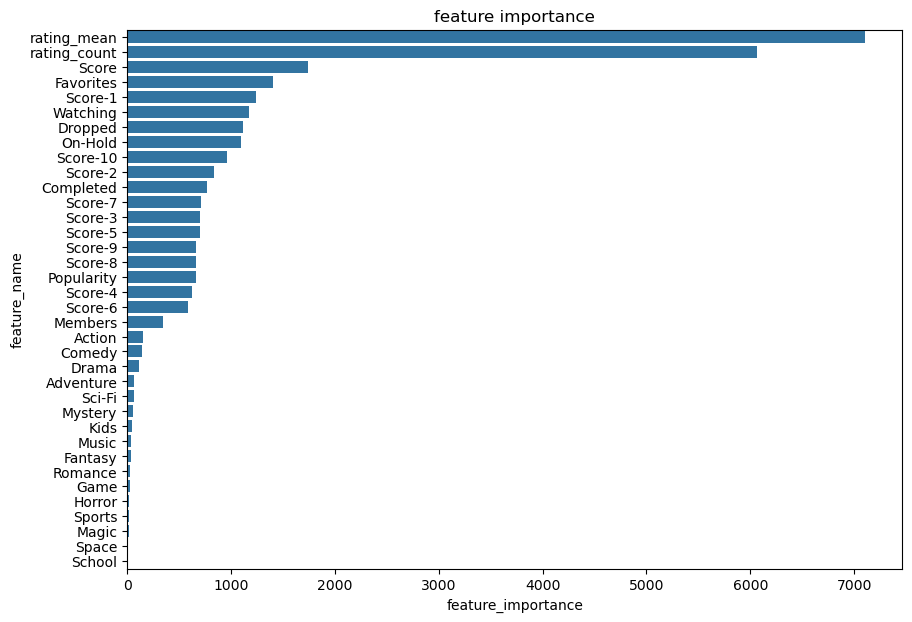

In [15]:
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance':
model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')


In [24]:
def predict(user_df, top_k, anime, rating):
    user_anime_df = anime.merge(user_df, left_on="MAL_ID", right_on="anime_id")
    user_anime_df = make_anime_feature(user_anime_df)

    excludes_genres = list(
        np.array(genre_names)[
            np.nonzero([user_anime_df[genre_names].sum(axis=0) <= 1])[1]
        ]
    )

    pred_df = make_anime_feature(anime.copy())
    pred_df = pred_df.loc[pred_df[excludes_genres].sum(axis=1) == 0]

    for col in user_df.columns:
        if col in features:
            pred_df[col] = user_df[col].values[0]

    preds = model.predict(pred_df[features])

    topk_idx = np.argsort(preds)[::-1][:top_k]

    recommend_df = pred_df.iloc[topk_idx].reset_index(drop=True)

    # check recommend
    print("---------- Recommend ----------")
    for i, row in recommend_df.iterrows():
        print(f'{i+1}: {row["Japanese name"]}:{row["English name"]}')

    print("---------- Rated ----------")
    user_df = user_df.merge(anime, left_on="anime_id", right_on="MAL_ID", how="inner")
    for i, row in user_df.sort_values("rating", ascending=False).iterrows():
        print(f'rating:{row["rating"]}: {row["Japanese name"]}:{row["English name"]}')

    return recommend_df


In [36]:
user_id = 18
user_df = rating.copy().loc[rating['user_id'] == user_id]
user_df = make_user_feature(user_df)
predict(user_df, 10, anime, rating)


---------- Recommend ----------
1: Peeping Life（ピーピング・ライフ）-The Perfect Emotion-:Unknown
2: バイオレンス劇画 新・堕靡泥の星 淫魔伝説:Unknown
3: Peeping Life（ピーピング・ライフ） -The Perfect Evolution-:Unknown
4: うちの3姉妹:Unknown
5: 鉄人28号ガオ!:Unknown
6: JU 中古自動車販売士 × Peeping Life:Unknown
7: 桃屋×Peeping Life ご縁ですよ！:Unknown
8: それいけ! サブイボマスク:Unknown
9: あかねちゃん:Little Miss Akane
10: パンキー ファンキー ベイビー:Punky Funky Baby
---------- Rated ----------
rating:10: アオハライド:Blue Spring Ride
rating:10: エスカフローネ:Escaflowne:A Girl in Gaea
rating:10: 劇場版 鋼の錬金術師 シャンバラを征く者:Fullmetal Alchemist:The Movie - Conqueror of Shamballa


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Mystery,School,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,17161,Peeping Life: The Perfect Emotion Special,5.58,"Slice of Life, Comedy",Unknown,Peeping Life（ピーピング・ライフ）-The Perfect Emotion-,Special,1,"Apr 16, 2010",Unknown,...,0,0,0,0,0,0,0,0,3,10.0
1,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,5.22,Hentai,Unknown,バイオレンス劇画 新・堕靡泥の星 淫魔伝説,OVA,1,"Mar 8, 1991",Unknown,...,0,0,0,0,0,0,0,0,3,10.0
2,17163,Peeping Life: The Perfect Evolution Specials,5.72,"Slice of Life, Comedy",Unknown,Peeping Life（ピーピング・ライフ） -The Perfect Evolution-,Special,3,"Jan 27, 2011",Unknown,...,0,0,0,0,0,0,0,0,3,10.0
3,3975,Uchi no 3 Shimai,NaN,"Slice of Life, Comedy",Unknown,うちの3姉妹,TV,102,"Apr 8, 2008 to Mar 30, 2010",Spring 2008,...,0,0,0,0,0,0,0,0,3,10.0
4,19445,Tetsujin 28-gou Gao!,NaN,"Slice of Life, Mecha",Unknown,鉄人28号ガオ!,TV,151,"Apr 6, 2013 to Mar 26, 2016",Spring 2013,...,0,0,0,0,0,0,0,0,3,10.0
5,29752,JU Chuuko Jidousha Hanbaishi x Peeping Life,NaN,"Slice of Life, Comedy",Unknown,JU 中古自動車販売士 × Peeping Life,ONA,2,"Sep 30, 2013 to Nov 10, 2014",Unknown,...,0,0,0,0,0,0,0,0,3,10.0
6,19337,Momoya x Peeping Life: Go en Desu yo!,5.72,Slice of Life,Unknown,桃屋×Peeping Life ご縁ですよ！,ONA,4,"Apr 25, 2013 to May 16, 2013",Unknown,...,0,0,0,0,0,0,0,0,3,10.0
7,33188,Sore Ike! Sabuibo Mask,NaN,"Slice of Life, Comedy",Unknown,それいけ! サブイボマスク,TV,8,"May 6, 2016 to Jun 24, 2016",Spring 2016,...,0,0,0,0,0,0,0,0,3,10.0
8,18635,Akane-chan,NaN,"Slice of Life, Comedy, School, Shoujo",Little Miss Akane,あかねちゃん,TV,26,"Apr 6, 1968 to Sep 29, 1968",Spring 1968,...,0,0,0,0,0,0,0,0,3,10.0
9,12563,Punky Funky Baby,4.80,Hentai,Punky Funky Baby,パンキー ファンキー ベイビー,OVA,1,"May 1, 1985",Unknown,...,0,0,0,0,0,0,0,0,3,10.0
